In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline

In [17]:
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    print(f"Training data shape: {train.shape}")
    print(f"Test data shape: {test.shape}")
    return train, test

In [18]:
def preprocess_data(train, test):
    """Preprocess data with advanced missing value handling and feature engineering"""
    # Create copies to avoid warnings
    train_processed = train.copy()
    test_processed = test.copy()
    
    # Combine for preprocessing to ensure consistent transformations
    combined = pd.concat([train_processed, test_processed], ignore_index=True)
    
    # ---- MISSING VALUES HANDLING ----
    
    # 1. Item_Weight - Missing in ~17% of records
    # Use weight of same item identifier
    item_avg_weight = combined.pivot_table(values='Item_Weight', index='Item_Identifier')
    missing_weight = combined['Item_Weight'].isna()
    
    for idx in combined[missing_weight].index:
        item = combined.loc[idx, 'Item_Identifier']
        if item in item_avg_weight.index:
            combined.loc[idx, 'Item_Weight'] = item_avg_weight.loc[item]
        else:
            # If still no match, use average weight for the item type
            item_type = combined.loc[idx, 'Item_Type']
            combined.loc[idx, 'Item_Weight'] = combined[combined['Item_Type'] == item_type]['Item_Weight'].mean()
    
    # 2. Outlet_Size - Missing in ~28% of records
    # Impute based on Outlet_Type correlation
    outlet_size_by_type = combined.pivot_table(
        values='Outlet_Size',
        columns='Outlet_Type',
        aggfunc=lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan
    )
    
    missing_size = combined['Outlet_Size'].isna()
    for idx in combined[missing_size].index:
        outlet_type = combined.loc[idx, 'Outlet_Type']
        combined.loc[idx, 'Outlet_Size'] = outlet_size_by_type[outlet_type]
    
    # ---- FEATURE CLEANING ----
    
    # 1. Item_Fat_Content standardization
    fat_content_map = {
        'LF': 'Low Fat',
        'low fat': 'Low Fat',
        'reg': 'Regular'
    }
    combined['Item_Fat_Content'] = combined['Item_Fat_Content'].replace(fat_content_map)
    
    # 2. Extract Item Category from Item_Identifier and create new feature
    combined['Item_Category'] = combined['Item_Identifier'].str.slice(0, 2)
    category_map = {
        'FD': 'Food',
        'NC': 'Non-Consumable',
        'DR': 'Drinks'
    }
    combined['Item_Category'] = combined['Item_Category'].map(category_map)
    
    # 3. Set Item_Fat_Content for Non-Consumable as 'None'
    combined.loc[combined['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'None'
    
    # ---- FEATURE ENGINEERING ----
    
    # 1. Item visibility - Replace 0 with mean of same item type
    zero_visibility = combined['Item_Visibility'] == 0
    for idx in combined[zero_visibility].index:
        item_type = combined.loc[idx, 'Item_Type']
        visibility_mean = combined[
            (combined['Item_Type'] == item_type) & 
            (combined['Item_Visibility'] > 0)
        ]['Item_Visibility'].mean()
        
        if not np.isnan(visibility_mean):
            combined.loc[idx, 'Item_Visibility'] = visibility_mean
        else:
            combined.loc[idx, 'Item_Visibility'] = combined[combined['Item_Visibility'] > 0]['Item_Visibility'].mean()
    
    # 2. Log transform Item_Visibility to handle skewness
    combined['Item_Visibility_Log'] = np.log1p(combined['Item_Visibility'])
    
    # 3. Create Item_MRP price segments
    combined['Item_MRP_Segment'] = pd.qcut(
        combined['Item_MRP'], 
        q=4, 
        labels=['Budget', 'Economy', 'Premium', 'Luxury']
    )
    
    # 4. Years of operation
    combined['Outlet_Years'] = 2013 - combined['Outlet_Establishment_Year']
    
    # 5. Price per unit weight
    combined['Price_Per_Unit_Weight'] = combined['Item_MRP'] / combined['Item_Weight']
    
    # 6. Item visibility to MRP ratio
    combined['Visibility_to_MRP_Ratio'] = combined['Item_Visibility'] / combined['Item_MRP']
    
    # 7. Interaction features
    combined['Item_Type_X_Outlet_Type'] = combined['Item_Type'] + '_' + combined['Outlet_Type']
    combined['Item_Category_X_Outlet_Type'] = combined['Item_Category'] + '_' + combined['Outlet_Type']
    combined['Item_Fat_Content_X_Item_Category'] = combined['Item_Fat_Content'] + '_' + combined['Item_Category']
    
    # 8. Location and Outlet Type Combination
    combined['Location_X_Type'] = combined['Outlet_Location_Type'] + '_' + combined['Outlet_Type']
    
    # 9. Outlet identifier average sales (target encoding - careful with leakage!)
    # Only calculate from training data
    if 'Item_Outlet_Sales' in train.columns:
        outlet_avg_sales = train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].transform('mean')
        outlet_map = train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().to_dict()
        
        # Apply to both train and test
        combined['Outlet_Avg_Sales'] = combined['Outlet_Identifier'].map(outlet_map)
        
        # For items not in the map (should be rare), use global average
        combined['Outlet_Avg_Sales'].fillna(train['Item_Outlet_Sales'].mean(), inplace=True)
    
    # ---- ENCODING CATEGORICAL VARIABLES ----
    
    # Columns to encode
    cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                'Outlet_Location_Type', 'Outlet_Type', 'Item_MRP_Segment', 
                'Item_Category']
    
    # Apply one-hot encoding
    combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)
    
    # ---- DROP UNNECESSARY COLUMNS ----
    cols_to_drop = ['Item_Identifier', 'Outlet_Establishment_Year', 'Item_Type_X_Outlet_Type',
                    'Item_Category_X_Outlet_Type', 'Item_Fat_Content_X_Item_Category', 'Location_X_Type']
    combined.drop(cols_to_drop, axis=1, inplace=True)
    
    # Split back into train and test
    train_processed = combined.iloc[:len(train)]
    test_processed = combined.iloc[len(train):]
    
    # Ensure test has the same columns as train (in case of missing categories)
    if 'Item_Outlet_Sales' in test_processed.columns:
        test_processed.drop('Item_Outlet_Sales', axis=1, inplace=True)
    
    return train_processed, test_processed


In [19]:
def train_xgboost_model(X_train, y_train, X_test):
    """Train XGBoost model with optimized parameters"""
    # Define XGBoost model with tuned parameters
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        reg_alpha=0.001,
        reg_lambda=1,
        objective='reg:squarederror',
        random_state=42
    )
    
    # Fit model
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100,
        early_stopping_rounds=50
    )
    
    # Make predictions
    predictions = xgb_model.predict(X_test)
    
    # Return model and predictions
    return xgb_model, predictions


In [20]:
def train_gradient_boosting_model(X_train, y_train, X_test):
    """Train Gradient Boosting model with optimized parameters"""
    # Define GBM
    gb_model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=42
    )
    
    # Fit model
    gb_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = gb_model.predict(X_test)
    
    # Return model and predictions
    return gb_model, predictions


In [21]:
def train_random_forest_model(X_train, y_train, X_test):
    """Train Random Forest model with optimized parameters"""
    # Define RF
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = rf_model.predict(X_test)
    
    # Return model and predictions
    return rf_model, predictions


In [22]:
def evaluate_model(model, X, y, cv=5):
    """Evaluate model using cross-validation"""
    # Define cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Evaluate using RMSE
    rmse_scores = -cross_val_score(
        model, X, y, 
        scoring='neg_root_mean_squared_error',
        cv=kf,
        n_jobs=-1
    )
    
    print(f"Cross-validation RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    return rmse_scores.mean()

def create_ensemble_prediction(predictions_list, weights=None):
    """Create weighted ensemble of multiple model predictions"""
    if weights is None:
        # Use equal weights if not specified
        weights = [1/len(predictions_list)] * len(predictions_list)
    
    # Ensure weights sum to 1
    weights = np.array(weights) / sum(weights)
    
    # Create weighted prediction
    ensemble_prediction = np.zeros_like(predictions_list[0])
    for pred, weight in zip(predictions_list, weights):
        ensemble_prediction += weight * pred
    
    return ensemble_prediction


In [23]:
def main():
    # 1. Load data
    train, test = load_data("train_v9rqX0R.csv", "test_AbJTz2l.csv")
    
    # Save a copy of original test for submission
    original_test = test.copy()
    
    # 2. Preprocess data
    print("Preprocessing data...")
    train_processed, test_processed = preprocess_data(train, test)
    
    # 3. Prepare training data
    X_train = train_processed.drop('Item_Outlet_Sales', axis=1)
    y_train = train_processed['Item_Outlet_Sales']
    X_test = test_processed
    
    # 4. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 5. Train models
    print("Training XGBoost model...")
    xgb_model, xgb_preds = train_xgboost_model(X_train_scaled, y_train, X_test_scaled)
    
    print("Training Gradient Boosting model...")
    gb_model, gb_preds = train_gradient_boosting_model(X_train_scaled, y_train, X_test_scaled)
    
    print("Training Random Forest model...")
    rf_model, rf_preds = train_random_forest_model(X_train_scaled, y_train, X_test_scaled)
    
    # 6. Evaluate models with cross-validation
    print("\nModel Evaluation:")
    xgb_rmse = evaluate_model(xgb_model, X_train_scaled, y_train)
    gb_rmse = evaluate_model(gb_model, X_train_scaled, y_train)
    rf_rmse = evaluate_model(rf_model, X_train_scaled, y_train)
    
    # 7. Create ensemble prediction
    # Calculate weights based on inverse of RMSE
    inverse_rmse = [1/xgb_rmse, 1/gb_rmse, 1/rf_rmse]
    weights = [w/sum(inverse_rmse) for w in inverse_rmse]
    
    print(f"\nUsing ensemble weights: XGBoost={weights[0]:.2f}, GBM={weights[1]:.2f}, RF={weights[2]:.2f}")
    
    ensemble_preds = create_ensemble_prediction(
        [xgb_preds, gb_preds, rf_preds],
        weights=weights
    )
    
    # 8. Create submission file
    submission = pd.DataFrame({
        'Item_Identifier': original_test['Item_Identifier'],
        'Outlet_Identifier': original_test['Outlet_Identifier'],
        'Item_Outlet_Sales': ensemble_preds
    })
    
    # 9. Save submission
    submission.to_csv('ensemble_submission.csv', index=False)
    print("\nSubmission file saved as 'ensemble_submission.csv'")
    
    # 10. Feature importance analysis
    plt.figure(figsize=(12, 10))
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)
    
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Top 20 Features by Importance (XGBoost)')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("Feature importance plot saved as 'feature_importance.png'")
    
    return {
        'xgb_model': xgb_model,
        'gb_model': gb_model,
        'rf_model': rf_model,
        'ensemble_preds': ensemble_preds,
        'submission': submission
    }


In [24]:
if __name__ == "__main__":
    main()

Training data shape: (8523, 12)
Test data shape: (5681, 11)
Preprocessing data...


ValueError: Incompatible indexer with Series

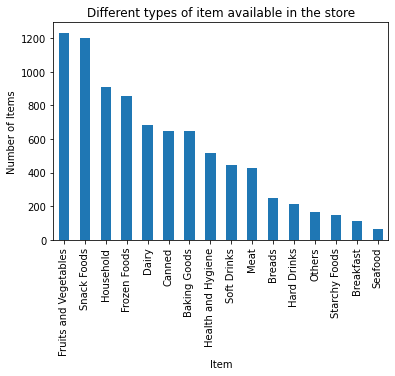

In [8]:
train['Item_Type'].value_counts(normalize = True)
train['Item_Type'].value_counts().plot.bar()
plt.title('Different types of item available in the store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

In [9]:
train['Outlet_Identifier'].value_counts()


OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

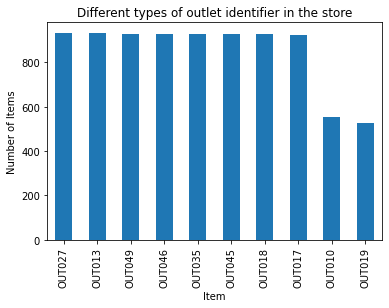

In [10]:
train['Outlet_Identifier'].value_counts(normalize = True)
train['Outlet_Identifier'].value_counts().plot.bar()
plt.title('Different types of outlet identifier in the store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

In [11]:
train['Outlet_Size'].value_counts()


Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

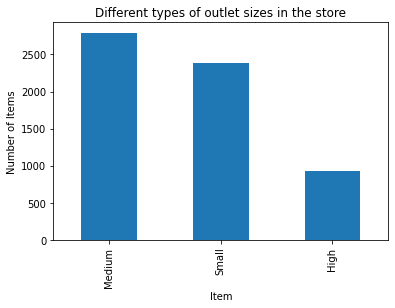

In [12]:
train['Outlet_Size'].value_counts(normalize = True)
train['Outlet_Size'].value_counts().plot.bar()
plt.title('Different types of outlet sizes in the store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

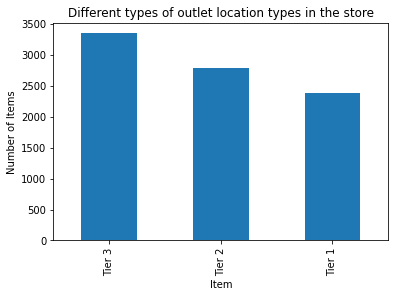

In [13]:
train['Outlet_Location_Type'].value_counts(normalize = True)
train['Outlet_Location_Type'].value_counts().plot.bar()
plt.title('Different types of outlet location types in the store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

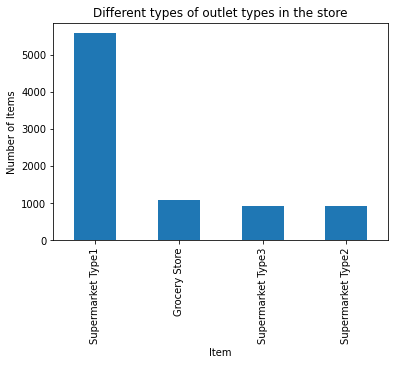

In [14]:
train['Outlet_Type'].value_counts(normalize = True)
train['Outlet_Type'].value_counts().plot.bar()
plt.title('Different types of outlet types in the store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

<AxesSubplot:xlabel='Item_Fat_Content'>

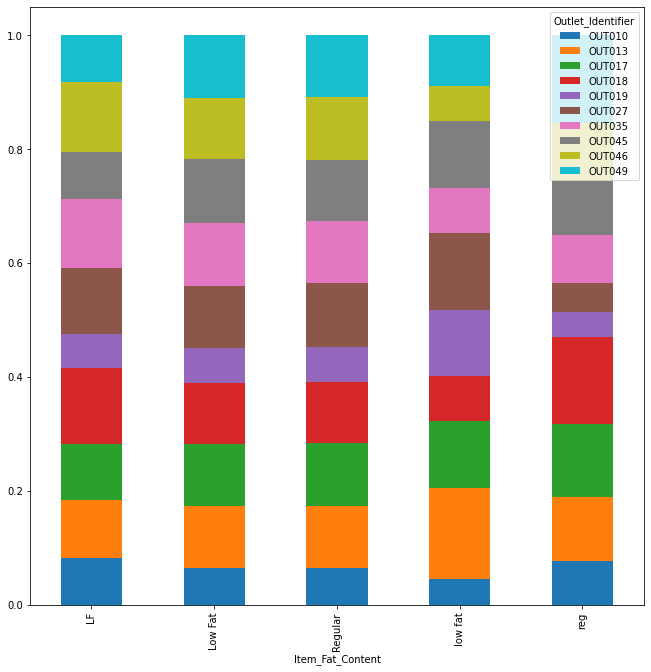

In [15]:
Item_Fat_Content = pd.crosstab(train['Item_Fat_Content'],train['Outlet_Identifier'])
Item_Fat_Content.div(Item_Fat_Content.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(11, 11))

<AxesSubplot:xlabel='Item_Type'>

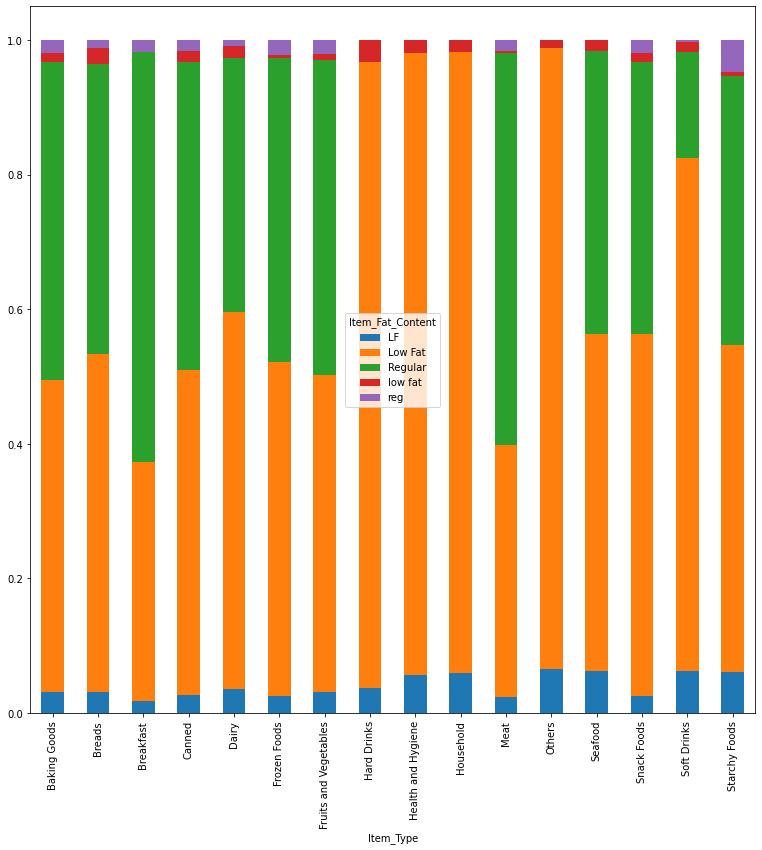

In [16]:
Item_Type = pd.crosstab(train['Item_Type'], train['Item_Fat_Content'])
Item_Type.div(Item_Type.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(13, 13))


In [17]:

data = pd.concat([train, test])

print(data.shape)

(14204, 12)


In [18]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
dtype: int64

In [19]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [20]:
data['Item_Weight'] = data['Item_Weight'].replace(0, np.NaN)
data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace = True)

data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace = True)

data['Item_Outlet_Sales'] = data['Item_Outlet_Sales'].replace(0, np.NaN)
data['Item_Outlet_Sales'].fillna(data['Item_Outlet_Sales'].mode()[0], inplace = True)

data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [21]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [22]:
data['Item_Identifier'] = data['Item_Identifier'].apply(lambda x: x[0:2])

data['Item_Identifier'] = data['Item_Identifier'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})

data['Item_Identifier'].value_counts()

Food              10201
Non_Consumable     2686
Drinks             1317
Name: Item_Identifier, dtype: int64

In [23]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].value_counts()

28    2439
26    1553
14    1550
16    1550
9     1550
11    1548
4     1546
6     1543
15     925
Name: Outlet_Years, dtype: int64

In [24]:
data = data.drop('Item_Identifier', axis = 1)

print(data.shape)

In [25]:
data['Outlet_Type'].value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [26]:
#!pip install scikit-learn

In [27]:
# label encoding

from sklearn.preprocessing import LabelEncoder

data.apply(LabelEncoder().fit_transform)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years
0,1,284,0,1097,4,7567,9,4,1,0,1,2540,4
1,0,57,1,1436,14,632,3,8,1,2,2,422,0
2,1,376,0,1172,10,3897,9,4,1,0,1,1639,4
3,1,393,1,0,6,5626,0,3,1,2,0,670,5
4,2,265,0,0,9,848,1,1,0,2,1,865,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,1,298,1,718,13,3881,8,2,2,0,1,835,6
5677,1,180,1,11820,15,5069,3,8,1,2,2,835,0
5678,2,293,0,8009,8,3196,7,5,1,1,1,835,3
5679,1,354,1,0,3,6626,2,7,1,1,1,835,1


In [28]:
data = pd.get_dummies(data)

print(data.shape)

(14204, 47)


In [29]:
x = data.drop('Item_Outlet_Sales', axis = 1)
y = data.Item_Outlet_Sales

print(x.shape)
print(y.shape)

(14204, 46)
(14204,)


In [30]:
train = data.iloc[:8523,:]
test = data.iloc[8523:,:]

print(train.shape)
print(test.shape)

(8523, 47)
(5681, 47)


In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9942, 46)
(9942,)
(4262, 46)
(4262,)


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
print('RMSE :', np.sqrt(mse))
print('Variance score: %.2f' % r2_score(y_test, y_pred))


[2016.  976. 2304. ... 1552. -224. 1120.]
RMSE : 1239.1110271320476
Variance score: 0.29


In [33]:
from sklearn.ensemble import AdaBoostRegressor

model= AdaBoostRegressor(n_estimators = 100)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
print("RMSE :", np.sqrt(mse))


RMSE : 1349.9742814911579


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
print(y_pred)

print("RMSE :", np.sqrt(((y_test - y_pred)**2).sum()/len(y_test)))

[2007.6538692   918.97508051 2140.05840882 ... 1591.87764216  512.84025094
 1056.40921751]
RMSE : 1229.2986982643645


In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 100 , n_jobs = -1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
print("RMSE :",np.sqrt(mse))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

print("Result :",model.score(x_train, y_train))


[2433.811926  776.036506 1907.110862 ... 1300.800092  429.747268
 1122.585406]
RMSE : 1301.130552476125
Variance score: 0.21
Result : 0.8872988573193896


In [36]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(x_train, y_train)

# predicting the test set results
y_pred = model.predict(x_test)
print(y_pred)

print(" RMSE : " , np.sqrt(((y_test - y_pred)**2).sum()/len(y_test)))

[2864.2716  679.116   958.752  ... 2403.538   126.502   958.752 ]
 RMSE :  1800.2328611577723


In [37]:
from sklearn.svm import SVR

model = SVR()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE :", np.sqrt(mse))


RMSE : 1647.5102626712187


In [38]:
import numpy as np

x_train = np.asmatrix(x_train)
x_test = np.asmatrix(x_test)
y_train = np.asmatrix(y_train.T)
y_test = np.asmatrix(y_test.T)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9942, 46)
(4262, 46)
(1, 9942)
(1, 4262)


In [40]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.8.0


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime

input_dim = x_train.shape[1]


model = Sequential([
    Dense(20, activation='relu', input_shape=(input_dim,)),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mse',
              metrics=['mae'])


model.summary()


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

y_train_array = np.array(y_train).reshape(-1)  
y_test_array = np.array(y_test).reshape(-1)   


print("x_train shape:", x_train.shape)
print("y_train shape after reshaping:", y_train_array.shape)

# Train the model
history = model.fit(
    x_train, y_train_array,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test_array),
    callbacks=[tensorboard_callback],
    verbose=1
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                940       
                                                                 
 dense_9 (Dense)             (None, 15)                315       
                                                                 
 dense_10 (Dense)            (None, 10)                160       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,426
Trainable params: 1,426
Non-trainable params: 0
_________________________________________________________________
x_train shape: (9942, 46)
y_train shape after reshaping: (9942,)
Epoch 1/100
311/311 [==============================] - 2s 3ms/step - loss: 4794680.0000 - mae: 1647.0764 - val_loss: 45

In [44]:

y_pred = model.predict(x_test)


y_pred = y_pred.flatten() 


mse = mean_squared_error(y_test_array, y_pred)
print("TensorFlow 2.0 Model RMSE:", np.sqrt(mse))
print("TensorFlow 2.0 Model R² Score:", r2_score(y_test_array, y_pred))


TensorFlow 2.0 Model RMSE: 1317.3202514401823
TensorFlow 2.0 Model R² Score: 0.1934291060594312


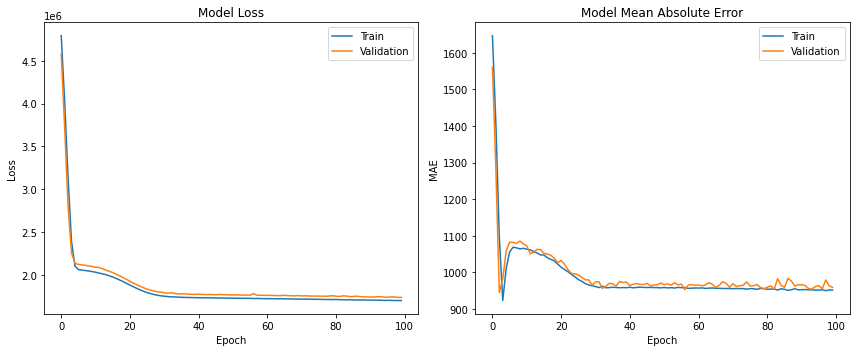

In [45]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# training & validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


For model comparison:
x_train shape: (9942, 46)
y_train shape: (9942,)
x_test shape: (4262, 46)
y_test shape: (4262,)
                             RMSE        R²
Linear Regression     1239.111027  0.286358
Decision Tree         1775.167001 -0.464665
Random Forest         1298.417516  0.216411
Gradient Boosting     1229.025905  0.297928
AdaBoost              1295.397944  0.220051
SVR                   1647.510263 -0.261584
Neural Network (TF2)  1317.320251  0.193429


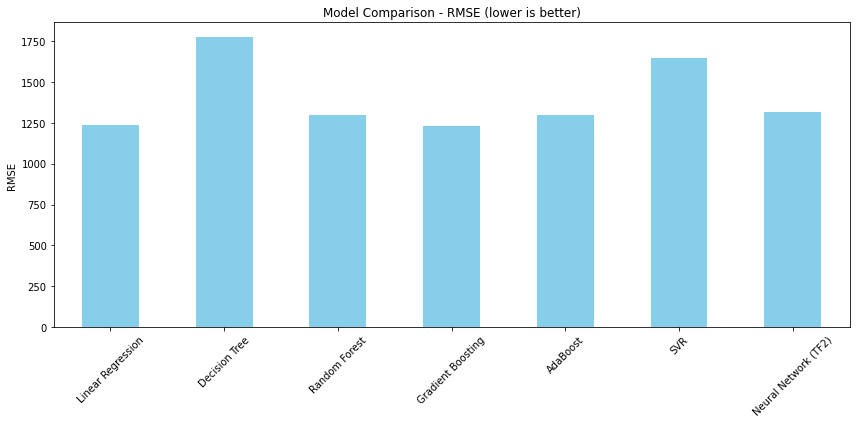

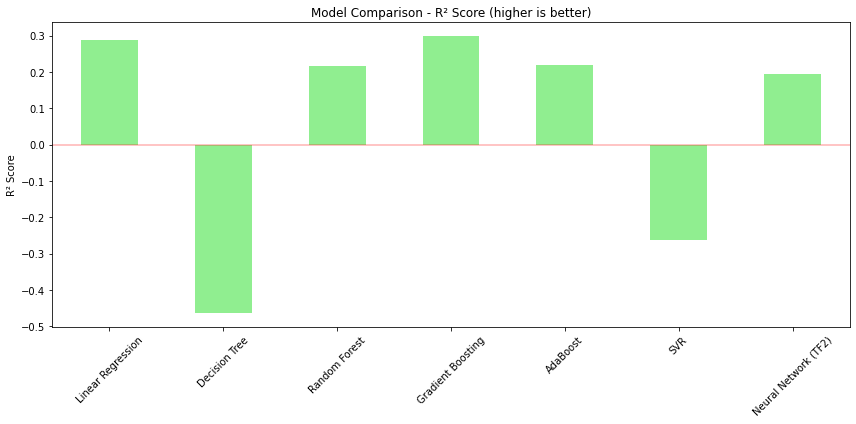

In [47]:
# Compare all models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(n_estimators=100),
    'SVR': SVR(),
    'Neural Network (TF2)': None  
}

results = {}

x_train_array = np.array(x_train)
y_train_array = np.array(y_train).reshape(-1)  
x_test_array = np.array(x_test)
y_test_array = np.array(y_test).reshape(-1)   

print("For model comparison:")
print("x_train shape:", x_train_array.shape)
print("y_train shape:", y_train_array.shape)
print("x_test shape:", x_test_array.shape)
print("y_test shape:", y_test_array.shape)


for name, model_instance in models.items():
    if model_instance is not None: 
        model_instance.fit(x_train_array, y_train_array)
        y_pred = model_instance.predict(x_test_array)
        rmse = np.sqrt(mean_squared_error(y_test_array, y_pred))
        r2 = r2_score(y_test_array, y_pred)
        results[name] = {'RMSE': rmse, 'R²': r2}


nn_pred = model.predict(x_test_array).flatten() 
nn_rmse = np.sqrt(mean_squared_error(y_test_array, nn_pred))
nn_r2 = r2_score(y_test_array, nn_pred)
results['Neural Network (TF2)'] = {'RMSE': nn_rmse, 'R²': nn_r2}


results_df = pd.DataFrame(results).T
print(results_df)

# comparison of RMSE
plt.figure(figsize=(12, 6))
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('Model Comparison - RMSE (lower is better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# comparison of R squared
plt.figure(figsize=(12, 6))
results_df['R²'].plot(kind='bar', color='lightgreen')
plt.title('Model Comparison - R² Score (higher is better)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
original_test = pd.read_csv("test_AbJTz2l.csv")

gb_model = GradientBoostingRegressor()
gb_model.fit(x_train_array, y_train_array)


submission_predictions = gb_model.predict(test.drop('Item_Outlet_Sales', axis=1))


submission = pd.DataFrame({
    'Item_Identifier': original_test['Item_Identifier'],
    'Outlet_Identifier': original_test['Outlet_Identifier'],
    'Item_Outlet_Sales': submission_predictions
})


submission.to_csv('submission_gradient_boosting.csv', index=False)
print("Gradient Boosting submission file saved successfully!")

Gradient Boosting submission file saved successfully!


C:\Users\Uma_pc\anaconda3\envs\tensor\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [54]:
original_test = pd.read_csv("test_AbJTz2l.csv")
original_test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [56]:
test['Item_Outlet_Sales']

0       958.752
1       958.752
2       958.752
3       958.752
4       958.752
         ...   
5676    958.752
5677    958.752
5678    958.752
5679    958.752
5680    958.752
Name: Item_Outlet_Sales, Length: 5681, dtype: float64

In [58]:
submission_predictions

array([1376.46194657, 1190.84800291,  683.74870041, ..., 1469.50753496,
       2564.99208202, 1150.43227855])